# Simulating FM modulation of the axial frequency using RF on Ring electrode

In [1]:
import scipy.constants as cont
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import chirp
from scipy.signal import windows

import copy
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from fticr_toolkit import ame
from fticr_toolkit import ideal_trap_physics as ideal
from fticr_toolkit import systematics as sys

pi2 = 2 * np.pi

### ion

In [12]:
m = 178
dm = 100 / 0.931e9
q = 42

nuz = 500e3

U0 = ideal.U0(q, m, nuz, c2=-1.496e4)
print(U0)

-14.489305581005445


### voltage modulation -> nu_z modulation

In [130]:
t = np.arange(0, 1e-1, 1e-4)

A = 5e-3
deltaf = A/U0/2*nuz
print(deltaf)

fm = 1e2
modulation_index = deltaf/fm
print(modulation_index)
phim = 0

TR = 0.88 # Uc/U0
dTR = (U0*TR)/(U0+A) - TR
print('dTR', dTR, "that is ok...")

Ut = U0 + A*np.sin(pi2*fm*t+phim)

-86.27052504425541
-0.8627052504425541
dTR 0.0003037770761873393 that is ok...


86.26308372465428


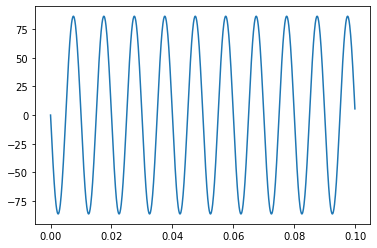

In [131]:
dnuz_t = ideal.omegaz(q, m, Ut) / pi2 - nuz
#dnuz_t = ideal.domegaz(q, m, Ut) / pi2 - nuz
print(max(dnuz_t))
plt.plot(t, dnuz_t)
plt.show()

to get something like 1 kHz, obviously quite the amplitude is neccessary as a modulation on U0... this is probably pretty bad, since it is by itself a modulation of the TR and that is ugly...

a reduce this one would either take higher order sidebands in the end or try to somehow modulate the correction electrodes too, which is not an easy thing regarding phase shifts and splitted electrodes.

In [132]:
def generateSignalFM(t, A_carrier, f_carrier, df_modulation, f_modulation, phase_carrier=0, phase_modulation=0):
    return A_carrier * np.cos(pi2 *(f_carrier + df_modulation*np.sin(pi2*f_modulation*t+phase_modulation))*t + phase_carrier)
    #return A_carrier * np.cos(pi2*(f_carrier)*t)

df_modulation = max(dnuz_t) # 20
print(df_modulation)
f_modulation = fm # nuz/10
f_carrier = nuz
print(f_carrier)
A_carrier = 1
SAMPLING_RATE = 5e-8
SAMPLE_LENGTH = 5e-1

t = np.arange(0, SAMPLE_LENGTH, SAMPLING_RATE)
print(t)


86.26308372465428
500000.0
[0.0000000e+00 5.0000000e-08 1.0000000e-07 ... 4.9999985e-01 4.9999990e-01
 4.9999995e-01]


86.26308372465428
2.0


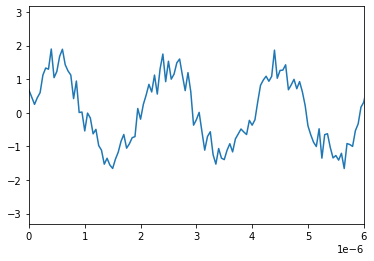

In [133]:
import random

def genSuperSignal(t, A_carrier, f_carrier, df_modulation, f_modulation, phasediff=0, noiseBackground=-10):
    phase_carrier = random.uniform(0, 1)*2*np.pi
    phase_off = (phase_carrier+phasediff)%(2*np.pi)
    signal1 = generateSignalFM(t, A_carrier, f_carrier, df_modulation, f_modulation, phase_carrier=phase_carrier)# np.pi*2.53)
    signal2 = generateSignalFM(t, A_carrier, f_carrier*(1+1e-11), df_modulation, f_modulation, phase_carrier=phase_off)

    signal = signal1 + signal2
    A_noise = 10**(noiseBackground/20) * A_carrier
    #print(A_noise)
    noise = np.random.normal(0, A_noise, size=len(signal))
    signal += noise
    return signal
    
dB_noise = -10 # dB = 20 × log (V2 / V1) -> 10^(dB/20) * A_carrier
signal = genSuperSignal(t, A_carrier, f_carrier, df_modulation, f_modulation, np.pi/2, dB_noise)
print(df_modulation)
print(1/SAMPLE_LENGTH)
plt.plot(t, signal)
plt.xlim(0, 3/f_carrier)
plt.show()

In [134]:


def myfft(signal):
    # Number of samples 
    N = len(signal)
    print(N, signal)

    # window
    wtype = ("hann")
    window = windows.get_window(wtype, N, fftbins=False)
    signal *= window

    # normalize
    normalized_signal = np.int16((signal / signal.max()) * 32767)
    signal = normalized_signal

    # FFT
    yf = fft(signal)
    xf = fftfreq(N, SAMPLING_RATE)
    print(yf, xf)
    return xf, yf

xf, yf = myfft(signal)

10000000 [ 0.67358898  0.46472437  0.25085138 ... -0.72899112 -0.57660948
  0.29600536]
[-3678760.              -0.j          3473761.66039767-2193749.49470236j
 -1166508.82510863+1637927.7408255j  ...
  1024070.10377158+3315081.07456427j -1166508.82510863-1637927.7408255j
  3473761.66039767+2193749.49470236j] [ 0.  2.  4. ... -6. -4. -2.]


215 499786.0 500214.0


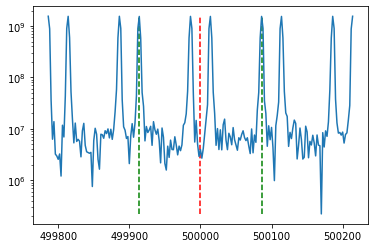

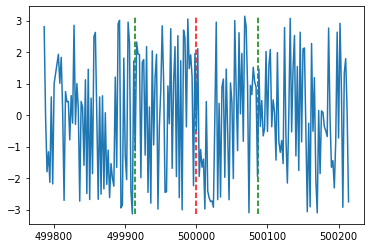

In [135]:

# show this
span = df_modulation * 5
x_axial = xf[np.where(abs(xf-f_carrier) < span/2)]
y_axial = yf[np.where(abs(xf-f_carrier) < span/2)]
print(len(x_axial), min(x_axial), max(x_axial))
#print(x_axial, y_axial)
plt.plot(x_axial, np.abs(y_axial))
plt.yscale("log")
#plt.ylim([1e6, 1e12])
plt.vlines([f_carrier], min(np.abs(y_axial)), max(np.abs(y_axial)), colors='r', linestyles='dashed')
plt.vlines([f_carrier-df_modulation], min(np.abs(y_axial)), max(np.abs(y_axial)), colors='g', linestyles='dashed')
plt.vlines([f_carrier+df_modulation], min(np.abs(y_axial)), max(np.abs(y_axial)), colors='g', linestyles='dashed')
plt.show()

#print(x_axial, y_axial)
plt.plot(x_axial, np.angle(y_axial))
#plt.yscale("log")
#plt.ylim([1e6, 1e12])
plt.vlines([f_carrier], min(np.angle(y_axial)), max(np.angle(y_axial)), colors='r', linestyles='dashed')
plt.vlines([f_carrier-df_modulation], min(np.angle(y_axial)), max(np.angle(y_axial)), colors='g', linestyles='dashed')
plt.vlines([f_carrier+df_modulation], min(np.angle(y_axial)), max(np.angle(y_axial)), colors='g', linestyles='dashed')
plt.show()

In [136]:
phases = np.arange(0, np.pi*2, np.pi/10)

left = []
right = []
carrier = []

for dphi in phases:
    signal = genSuperSignal(t, A_carrier, f_carrier, df_modulation, f_modulation, dphi, dB_noise)
    xf, yf = myfft(signal)
    cidx = np.where(abs(xf-(f_carrier)) < 1/SAMPLE_LENGTH*0.999)
    lidx = np.where(abs(xf-(f_carrier-df_modulation)) < 1/SAMPLE_LENGTH*0.9)
    ridx = np.where(abs(xf-(f_carrier+df_modulation)) < 1/SAMPLE_LENGTH*0.9)
    print(dphi, cidx, lidx, ridx, min(xf[lidx]), min(xf[ridx]))
    cphi = np.angle(yf[cidx])[0]
    lphi = np.angle(yf[lidx])[0]
    rphi = np.angle(yf[ridx])[0]
    carrier.append(cphi)
    left.append(lphi)
    right.append(rphi)
    

10000000 [2.24086021 1.72147081 1.52913468 ... 1.8860687  2.68587626 1.82586269]
[-4995888.              -0.j          4447819.46591045 +821269.75743428j
   723071.80145967-1375466.15514799j ...
 -7346344.52327248 -628997.69943711j   723071.80145967+1375466.15514799j
  4447819.46591045 -821269.75743428j] [ 0.  2.  4. ... -6. -4. -2.]
0.0 (array([250000], dtype=int64),) (array([249956, 249957], dtype=int64),) (array([250043, 250044], dtype=int64),) 499912.0 500086.0
10000000 [0.92616706 0.40472229 0.11511565 ... 1.18742725 0.92245872 1.03763932]
[  485837.              -0.j         -1152173.54771278+1103980.96787086j
  -773700.8924257 +3092893.08626874j ...
  2866633.80027348+4329967.15309917j  -773700.8924257 -3092893.08626874j
 -1152173.54771278-1103980.96787086j] [ 0.  2.  4. ... -6. -4. -2.]
0.3141592653589793 (array([250000], dtype=int64),) (array([249956, 249957], dtype=int64),) (array([250043, 250044], dtype=int64),) 499912.0 500086.0
10000000 [-1.09646827 -1.96408798 -1.18962453

5.026548245743669 (array([250000], dtype=int64),) (array([249956, 249957], dtype=int64),) (array([250043, 250044], dtype=int64),) 499912.0 500086.0
10000000 [1.01926294 0.65232398 0.79447383 ... 2.28882015 1.38356391 1.76515588]
[ 4279297.              -0.j         -4581447.81700402+4179772.85948916j
  -601551.49302708-3539886.38813606j ...
  6404414.08079927 +630738.55761616j  -601551.49302708+3539886.38813606j
 -4581447.81700402-4179772.85948916j] [ 0.  2.  4. ... -6. -4. -2.]
5.340707511102648 (array([250000], dtype=int64),) (array([249956, 249957], dtype=int64),) (array([250043, 250044], dtype=int64),) 499912.0 500086.0
10000000 [1.5342555  2.18970728 2.34035902 ... 1.54947662 1.8681133  1.72803428]
[-8536773.              -0.j          1901038.31841819+2719025.67767866j
  3113843.34969865-5784078.14438194j ...
 -1207464.21708508-6209693.26187344j  3113843.34969865+5784078.14438194j
  1901038.31841819-2719025.67767866j] [ 0.  2.  4. ... -6. -4. -2.]
5.654866776461628 (array([250000

[3.60760577 4.5799333  0.48456849 5.52278595 3.42243064 5.83556721
 0.41539006 5.3141829  1.69558253 4.46021237 5.82374491 2.27318145
 1.02338952 2.5241216  2.16771238 1.41853934 5.58578965 4.0360818
 2.98384462 1.12168831]


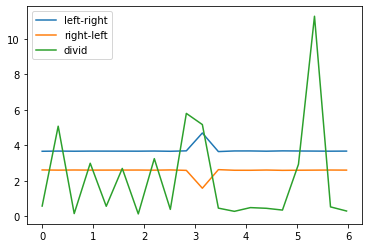

In [137]:
cari = np.asarray(cari)
left = np.asarray(left)
right = np.asarray(right)

cari[np.argwhere(cari<0)] += np.pi*2
left[np.argwhere(left<0)] += np.pi*2
right[np.argwhere(right<0)] += np.pi*2

period = np.pi/2
cari = np.unwrap(np.asarray(carrier),period=period)
#left = np.unwrap(np.asarray(left),period=period)
print(left)
#right = np.unwrap(np.asarray(right),period=period)
added = left+right
subtr = left-right
subtr2 = right-left
multip = left*right
divid = left/right
subtr[np.argwhere(subtr<0)] += np.pi*2
subtr2[np.argwhere(subtr2<0)] += np.pi*2
subtr3 = subtr - subtr2
subtr3[np.argwhere(subtr3<0)] += np.pi*2


#added = np.unwrap(added,period=period)
#addedcl = np.unwrap(cari+left,period=period)
#addedcr = np.unwrap(cari+right,period=period)
#addedcrl = np.unwrap(-cari+right+left,period=period)
#subtr = np.unwrap(subtr,period=period)
#subtr2 = np.unwrap(subtr2,period=period)
#multip = np.unwrap(multip,period=period)
#divid = np.unwrap(divid,period=period)

#plt.plot(phases, cari, label='carrier')
#plt.plot(phases, left, '.--', label='left')
#plt.plot(phases, right, label='right', ls='--')
#plt.plot(phases, added, label='added')
#plt.plot(phases, addedcl, label='addedlc')
#plt.plot(phases, addedcr, label='addedrc')
#plt.plot(phases, addedcrl, label='addedrcl')
plt.plot(phases, subtr, label='left-right')
plt.plot(phases, subtr2, label='right-left')
#plt.plot(phases, subtr3, label='sub-sub')
#plt.plot(phases, multip, label='multip')
plt.plot(phases, divid, label='divid')
plt.legend()
plt.show()